Imports and Checking GPU Access

In [17]:
import tensorflow as tf

In [18]:
print("Tensorflow version", tf.__version__)

Tensorflow version 2.11.1


In [19]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


Load in MNIST dataset

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [21]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [22]:
def loadMNIST():
    # Use keras' inbuilt datasets module to load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # x_train.shape = (60000, 28, 28)
    # y_train.shape = (60000, )
    # x_test.shape = (10000, 28, 28)
    # y_test.shape = (10000, )

    # Split 50:10 on train:validation, i.e. 50,000 datapoints for train, 10,000 for validation
    x_val, y_val = x_train[-10_000:, :, :], y_train[-10_000:]
    x_train, y_train = x_train[:-10_000, :, :], y_train[:-10_000]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [23]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loadMNIST()

In [24]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((50000, 28, 28),
 (50000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

Sampling data points

In [25]:
import matplotlib.pyplot as plt

In [26]:
idxs = tf.range(x_train.shape[0])
random_idxs = tf.random.shuffle(idxs)[:5] # pick 5 random indices
images = x_train[random_idxs, :, :]
labels = y_train[random_idxs]

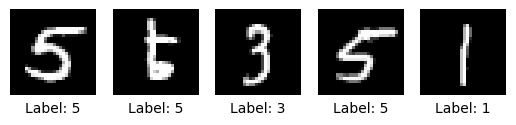

In [27]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    ax = axs[i]
    ax.imshow(images[i, :, :], cmap = 'gray')
    ax.axis('off')
    ax.text(0.5, -0.2, 'Label: ' + str(labels[i]), size = 10, ha = "center", transform = ax.transAxes)
plt.show()

Preprocessing

In [28]:
def preprocess(data):
    x_train, y_train, x_val, y_val, x_test, y_test = data

    x_train = tf.convert_to_tensor(x_train, dtype = tf.float32) / 255
    x_val   = tf.convert_to_tensor(x_val, dtype = tf.float32) / 255
    x_test  = tf.convert_to_tensor(x_test, dtype = tf.float32) / 255

    y_train = tf.one_hot(tf.convert_to_tensor(y_train), depth = 10)
    y_val   = tf.one_hot(tf.convert_to_tensor(y_val),  depth = 10)
    y_test  = tf.one_hot(tf.convert_to_tensor(y_test), depth = 10)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [29]:
x_train, y_train, x_val, y_val, x_test, y_test = preprocess((x_train, y_train, x_val, y_val, x_test, y_test))

Creating the Model

In [30]:
class CNN(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = (None, 28, 28, 1))
        self.drop1 = tf.keras.layers.Dropout(rate = 0.5)
                
        self.conv2 = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu', input_shape = (None, 28, 28, 1))
        self.drop2 = tf.keras.layers.Dropout(rate = 0.5)

        self.flatten = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(units = 10, activation = 'relu')
        self.dense2 = tf.keras.layers.Dense(units = 10, activation = 'softmax')

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, inputs.shape[1], inputs.shape[2], 1])
        
        x = self.conv1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.drop2(x)
        
        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)

        return x
    

In [31]:
model = CNN()

In [32]:
model.compile(optimizer = 'Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [33]:
model.build(input_shape = [None, 28, 28])

In [34]:
model.summary()

Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           multiple                  30        
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           multiple                  84        
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  17290     
                                                                 
 dense_3 (Dense)             multiple                  110   

In [35]:
print(x_train.shape, y_train.shape)

(50000, 28, 28) (50000, 10)


In [36]:
hist = model.fit(x_train, y_train, batch_size = 100, shuffle = True, validation_data = (x_val, y_val), epochs = 50)

Epoch 1/50


2023-05-12 14:15:05.043853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-12 14:15:06.260332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-12 14:15:07.283859: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-12 14:15:07.405705: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f54647db380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-12 14:15:07.405727: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2023-05-12 14:15:07.409203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR cr

500/500 [==============================] - 5s 3ms/step - loss: 0.8044 - accuracy: 0.7403 - val_loss: 0.2875 - val_accuracy: 0.9207
Epoch 2/50
500/500 [==============================] - 1s 3ms/step - loss: 0.3865 - accuracy: 0.8853 - val_loss: 0.2176 - val_accuracy: 0.9448
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 0.3210 - accuracy: 0.9052 - val_loss: 0.1927 - val_accuracy: 0.9494
Epoch 4/50
500/500 [==============================] - 1s 3ms/step - loss: 0.2840 - accuracy: 0.9153 - val_loss: 0.1642 - val_accuracy: 0.9584
Epoch 5/50
500/500 [==============================] - 1s 3ms/step - loss: 0.2578 - accuracy: 0.9230 - val_loss: 0.1561 - val_accuracy: 0.9584
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 0.2433 - accuracy: 0.9258 - val_loss: 0.1471 - val_accuracy: 0.9595
Epoch 7/50
500/500 [==============================] - 1s 3ms/step - loss: 0.2303 - accuracy: 0.9304 - val_loss: 0.1328 - val_accuracy: 0.9652
Epoch 8/50
500/50

Plotting Accuracy

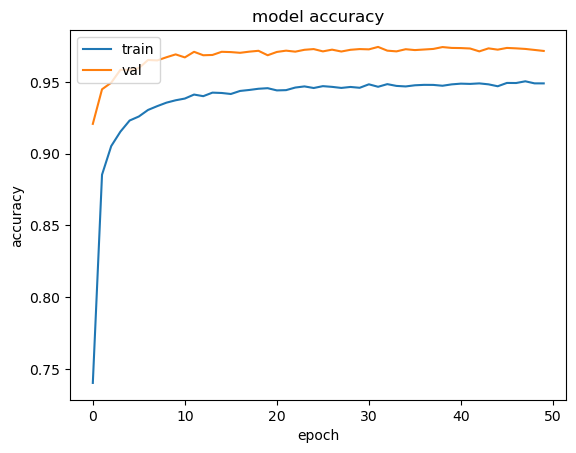

In [37]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Viewing Results

In [38]:
prob_test = model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [39]:
prob_test.shape

(10000, 10)

In [40]:
import numpy as np

In [41]:
pred_test = np.argmax(prob_test, axis = 1)

In [42]:
label_test = np.argmax(y_test, axis = 1)

In [44]:
idxs = tf.range(x_test.shape[0])
random_idxs = tf.random.shuffle(idxs)[:5] # pick 5 random indices
print(random_idxs)
images = np.array(x_test)[random_idxs, :, :]
labels = label_test[random_idxs]
preds = pred_test[random_idxs]

tf.Tensor([5857 9934 8106 7311 8505], shape=(5,), dtype=int32)


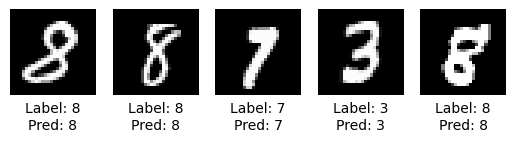

In [45]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    ax = axs[i]
    ax.imshow(images[i, :, :], cmap = 'gray')
    ax.axis('off')
    ax.text(0.5, -0.2, 'Label: ' + str(labels[i]), size = 10, ha = "center", transform = ax.transAxes)
    ax.text(0.5, -0.4, 'Pred: ' + str(preds[i]), size = 10, ha = "center", transform = ax.transAxes)
plt.show()

In [46]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9730


In [47]:
print(f'Loss = {test_loss:.4f}, \nAccuracy: {test_acc*100:.2f}%')

Loss = 0.0964, 
Accuracy: 97.30%
